# Gartex Timeseries Forecasting <img src = 'https://virasad.ir/img/virasad.svg' alt="Virasad-Logo" width="150" height="150" align="right">
### By Omid Vaheb
<br>
<br>
In this project I implemented some of learning algorithms on a time series signal and tried to forecast its future value in order to find anomalies.

### Importing:
The first step is to import libraries needed.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
!pip install plotly==2.7.0
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.plotly as py
from matplotlib import pyplot
import plotly.graph_objs as go
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
#######!pip install pyramid-arima
!pip install pmdarima
from pmdarima.arima import auto_arima
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Our dataset is a time series signal of number of units produced in different parts of a production line. CID determines section of production line and quantity shows number of units built in that time stamp.

In [43]:
data = pd.read_csv('/content/drive/My Drive/raw_data_production_line_dataset.csv');
data = data.iloc[1:]

In [44]:
data.head(10)

,date_stamp,quantity,CID
1,2019-11-19 04:37:22.288821,4.0,18.0
2,2019-11-19 04:41:55.463090,3.0,18.0
3,2019-11-19 04:42:26.914476,8.0,18.0
4,2019-11-19 04:50:06.426559,4.0,18.0
5,2019-11-19 04:51:53.901097,7.0,18.0
6,2019-11-19 04:52:37.981867,8.0,18.0
7,2019-11-19 04:54:47.696830,1.0,18.0
8,2019-11-19 04:55:13.875732,9.0,18.0
9,2019-11-19 04:59:26.475288,17.0,18.0
10,2019-11-19 05:02:33.961530,2.0,18.0


In [45]:
data.tail(10)

,date_stamp,quantity,CID
243654,2020-04-15 12:40:51.992726,1177.0,60.0
243655,2020-04-15 12:40:57.880163,1179.0,60.0
243656,2020-04-15 12:40:59.740009,452.0,38.0
243657,2020-04-15 12:41:04.273269,1181.0,60.0
243658,2020-04-15 12:41:10.708692,1183.0,60.0
243659,2020-04-15 12:41:17.257496,1185.0,60.0
243660,2020-04-15 12:41:17.869097,444.0,20.0
243661,2020-04-15 12:41:23.723851,454.0,38.0
243662,2020-04-15 12:41:49.241700,1187.0,60.0
243663,2020-04-15 12:41:50.966758,268.0,18.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243663 entries, 1 to 243663
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date_stamp  243663 non-null  object 
 1   quantity    243663 non-null  float64
 2   CID         243663 non-null  float64
dtypes: float64(2), object(1)
memory usage: 5.6+ MB


Our data is clean and does not need any preprocess.

In [46]:
data.isnull().sum()

date_stamp    0
quantity      0
CID           0
dtype: int64

The first row seems to have a wrong timestamp so i removed it fram dataset.

In [47]:
dataframe = data.sort_values(by = "date_stamp")
dataframe = dataframe.reset_index(drop = True)
dataframe = dataframe.drop([0])
dataframe = dataframe.reset_index(drop = True)
dataframe.head(10)

,date_stamp,quantity,CID
0,2019-11-02,122.0,18.0
1,2019-11-15,15.0,18.0
2,2019-11-16,16.0,18.0
3,2019-11-17,17.0,18.0
4,2019-11-18,18.0,18.0
5,2019-11-19 04:37:22.288821,4.0,18.0
6,2019-11-19 04:41:55.463090,3.0,18.0
7,2019-11-19 04:42:26.914476,8.0,18.0
8,2019-11-19 04:50:06.426559,4.0,18.0
9,2019-11-19 04:51:53.901097,7.0,18.0


I used groupby to check distribution of data amongst CIDs and it is clear that the ones with most data are CID 18 and 60.

In [48]:
dataframe.groupby(['CID']).CID.count()

CID
18.0    66968
20.0    50597
33.0    24278
38.0    40008
60.0    61811
Name: CID, dtype: int64

The next step is to divide dataset into 5 signals, one for each CID.

In [49]:
df18 = dataframe.loc[dataframe.CID == 18]
df18 = df18.reset_index(drop = True)
df20 = dataframe.loc[dataframe.CID == 20]
df20 = df20.reset_index(drop = True)
df33 = dataframe.loc[dataframe.CID == 33]
df33 = df33.reset_index(drop = True)
df38 = dataframe.loc[dataframe.CID == 38]
df38 = df38.reset_index(drop = True)
df60 = dataframe.loc[dataframe.CID == 60]
df60 = df60.reset_index(drop = True)

I faced so many problems while implementing learning methods on this signal and the reason was high number of samples without usefull information so i used a sample of signal instead of its original form. I picked 1 row in every 25 row and as you could see below the general form of time serie did not change at all.

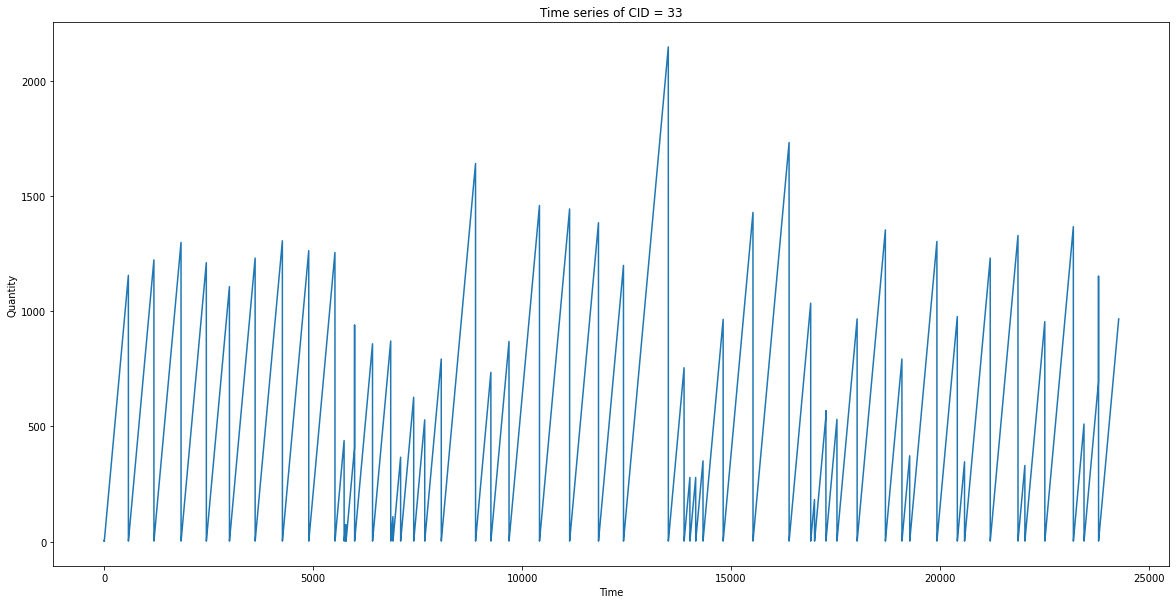

,date_stamp,quantity,CID
0,2020-01-02 09:33:23.368919,2.0,33.0
1,2020-01-02 09:33:30.514028,4.0,33.0
2,2020-01-02 09:34:04.323311,6.0,33.0
3,2020-01-04 04:32:26.171640,2.0,33.0
4,2020-01-04 04:33:07.404405,4.0,33.0
...,...,...,...
24273,2020-03-05 15:10:54.785506,958.0,33.0
24274,2020-03-05 15:11:33.055866,960.0,33.0
24275,2020-03-05 15:12:01.373541,962.0,33.0
24276,2020-03-05 15:12:47.392540,964.0,33.0


In [50]:
plt.figure(figsize = (20,10))
plt.plot(df33['quantity'])
plt.title('Time series of CID = 33')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.show()
df33

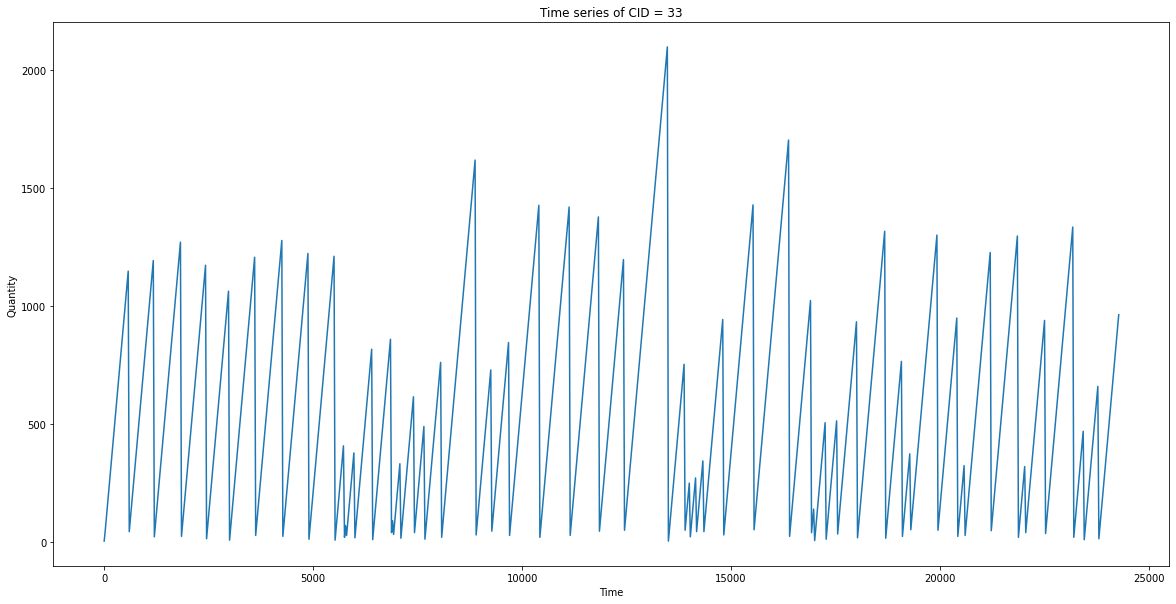

,date_stamp,quantity,CID
0,2020-01-02 09:33:23.368919,2.0,33.0
25,2020-01-04 04:57:24.045288,46.0,33.0
50,2020-01-04 05:18:25.224212,96.0,33.0
75,2020-01-04 05:43:06.123654,146.0,33.0
100,2020-01-04 06:04:06.143273,196.0,33.0
...,...,...,...
24175,2020-03-05 13:38:39.763679,762.0,33.0
24200,2020-03-05 14:02:12.903331,812.0,33.0
24225,2020-03-05 14:18:41.932115,862.0,33.0
24250,2020-03-05 14:49:37.302540,912.0,33.0


In [51]:
df33 = df33.loc[df33.index % 25 == 0]
plt.figure(figsize = (20,10))
plt.plot(df33['quantity'])
plt.title('Time series of CID = 33')
plt.xlabel('Time')
plt.ylabel('Quantity')
plt.show()
df33

In [52]:
quantity_vals = df33.quantity.values
quantity_log = np.log10(quantity_vals)

In the next step i used a an ARIMA model on the time series and predicted unknown values of last 30% of data with this model.

In [13]:
index = int(0.7 * len(df33))
train, test = quantity_vals[0:index], quantity_vals[index:]
train_log, test_log = np.log10(train), np.log10(test)
my_order = (1, 1, 1)
my_seasonal_order = (0, 1, 1, 7)

In [14]:
stepwise_model = auto_arima(train_log, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=7,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=3.55 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=1156.215, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=947.116, Time=0.29 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=2.54 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=1124.686, Time=0.08 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=858.101, Time=0.62 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=4.10 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=2.23 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=893.180, Time=0.43 sec
 ARIMA(2,1,0)(2,1,0)[7]             : AIC=852.665, Time=0.53 sec
 ARIMA(2,1,0)(1,1,0)[7]             : AIC=940.268, Time=0.36 sec
 ARIMA(2,1,0)(2,1,1)[7]             : AIC=inf, Time=4.50 sec
 ARIMA(2,1,0)(1,1,1)[7]             : AIC=inf, Time=4.42 sec
 ARIMA(3,1,0)(2,1,0)[7]             : AIC=848.697, Time=0.72 sec
 ARIMA(3,1,0)(1,1,0)[7]             : AIC=936.520, Time=0.49 sec
 ARI

In [15]:
train_log, test_log = np.log10(train), np.log10(test)
history = [x for x in train_log]
predictions = list()
predict_log = list()
for t in range(len(test_log)):
    stepwise_model.fit(history)
    output = stepwise_model.predict(n_periods=1)
    predict_log.append(output[0])
    yhat = 10**output[0]
    predictions.append(yhat)
    obs = test_log[t]
    history.append(obs)
    #print('predicted=%f, expected =%f' % (output[0], obs))
error = math.sqrt(mean_squared_error(test_log, predict_log))
print('Test rmse: %.3f' % error)

Test rmse: 0.454


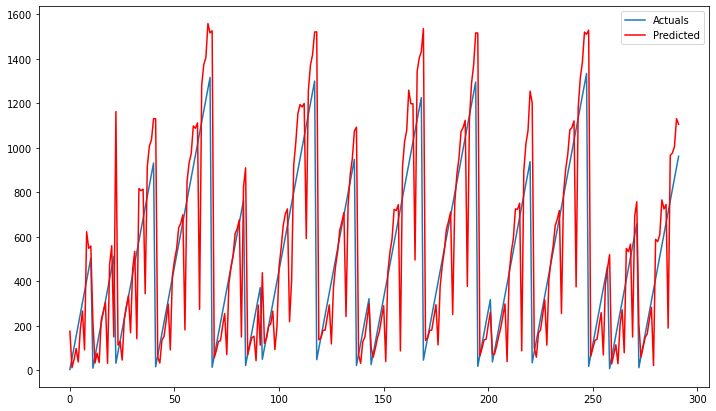

In [16]:
figsize = (12, 7)
plt.figure(figsize = figsize)
pyplot.plot(test, label = 'Actuals')
pyplot.plot(predictions, color = 'red', label = 'Predicted')
pyplot.legend(loc = 'upper right')
pyplot.show()

In [17]:
predicted_df = pd.DataFrame()
predicted_df['date_stamp'] = df33['date_stamp'][index:]
predicted_df['quantity'] = test
predicted_df['predicted'] = predictions
predicted_df.reset_index(inplace = True)
del predicted_df['index']
predicted_df.head()

,date_stamp,quantity,predicted
0,2020-02-18 13:27:48.777483,4.0,175.953856
1,2020-02-18 13:45:26.352691,54.0,11.769784
2,2020-02-18 14:04:21.600105,104.0,49.102018
3,2020-02-18 14:23:03.828822,154.0,97.968662
4,2020-02-18 14:43:12.392668,204.0,37.966556


Now I used some statistical concepts and found anomalies with their intensity and taged the highest intensity as anomaly.

In [27]:
def detect_classify_anomalies(df,window):
    df.replace([np.inf, -np.inf], np.NaN, inplace=True)
    df.fillna(0,inplace=True)
    df['error'] = df['quantity'] - df['predicted']
    df['percentage_change'] = ((df['quantity'] - df['predicted']) / df['quantity']) * 100
    df['meanval'] = df['error'].rolling(window = window).mean()
    df['deviation'] = df['error'].rolling(window = window).std()
    df['-3s'] = df['meanval'] - (2 * df['deviation'])
    df['3s'] = df['meanval'] + (2 * df['deviation'])
    df['-2s'] = df['meanval'] - (1.75 * df['deviation'])
    df['2s'] = df['meanval'] + (1.75 * df['deviation'])
    df['-1s'] = df['meanval'] - (1.5 * df['deviation'])
    df['1s'] = df['meanval'] + (1.5 * df['deviation'])
    cut_list = df[['error', '-3s', '-2s', '-1s', 'meanval', '1s', '2s', '3s']]
    cut_values = cut_list.values
    cut_sort = np.sort(cut_values)
    df['impact'] = [(lambda x: np.where(cut_sort == df['error'][x])[1][0])(x) for x in
                               range(len(df['error']))]
    severity = {0: 3, 1: 2, 2: 1, 3: 0, 4: 0, 5: 1, 6: 2, 7: 3}
    region = {0: "NEGATIVE", 1: "NEGATIVE", 2: "NEGATIVE", 3: "NEGATIVE", 4: "NEGATIVE", 5: "POSITIVE", 6: "POSITIVE",
              7: "POSITIVE"}
    df['color'] =  df['impact'].map(severity)
    df['region'] = df['impact'].map(region)
    df['anomaly_points'] = np.where(df['color'] == 3, df['error'], np.nan)
    df = df.sort_values(by = 'date_stamp', ascending = True)
    return df

In [28]:
classify_df = detect_classify_anomalies(predicted_df,7)
classify_df.reset_index(inplace = True)
del classify_df['index']


In [29]:
classify_df.head(10)

,date_stamp,quantity,predicted,error,percentage_change,meanval,deviation,-3s,3s,-2s,2s,-1s,1s,impact,color,region,anomaly_points
0,2020-02-18 13:27:48.777483,4.0,175.953856,-171.953856,-4298.846409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,-171.953856
1,2020-02-18 13:45:26.352691,54.0,11.769784,42.230216,78.204105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,42.230216
2,2020-02-18 14:04:21.600105,104.0,49.102018,54.897982,52.786521,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,54.897982
3,2020-02-18 14:23:03.828822,154.0,97.968662,56.031338,36.383986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,56.031338
4,2020-02-18 14:43:12.392668,204.0,37.966556,166.033444,81.388943,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,166.033444
5,2020-02-18 15:01:19.184530,254.0,185.946569,68.053431,26.792689,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,3,NEGATIVE,68.053431
6,2020-02-18 15:22:22.584604,304.0,266.736710,37.263290,12.257661,36.079406,101.636346,-167.193286,239.352098,-141.784199,213.943012,-116.375113,188.533925,4,0,NEGATIVE,NaN
7,2020-02-18 15:55:27.517588,354.0,92.417736,261.582264,73.893295,98.013138,84.363175,-70.713212,266.739487,-49.622418,245.648694,-28.531624,224.557900,6,2,POSITIVE,NaN
8,2020-02-18 16:14:40.386982,404.0,623.008622,-219.008622,-54.210055,60.693304,147.390945,-234.088586,355.475193,-197.240849,318.627457,-160.393113,281.779721,1,2,NEGATIVE,NaN
9,2020-02-18 16:34:01.428658,454.0,548.515010,-94.515010,-20.818284,39.348591,158.751063,-278.153536,356.850718,-238.465770,317.162952,-198.778005,277.475186,3,0,NEGATIVE,NaN


In [30]:
classify_df = classify_df.loc[:, ['date_stamp', 'quantity', 'predicted', 'region']]

In [31]:
classify_df['Anomaly'] = (classify_df['region'] == 'POSITIVE')

About 10% of data is labeled as anomaly. I created a signal for anomaly which is 1 when it is anomaly and 0 when it is not.

In [32]:
classify_df.Anomaly.value_counts()

False    261
True      31
Name: Anomaly, dtype: int64

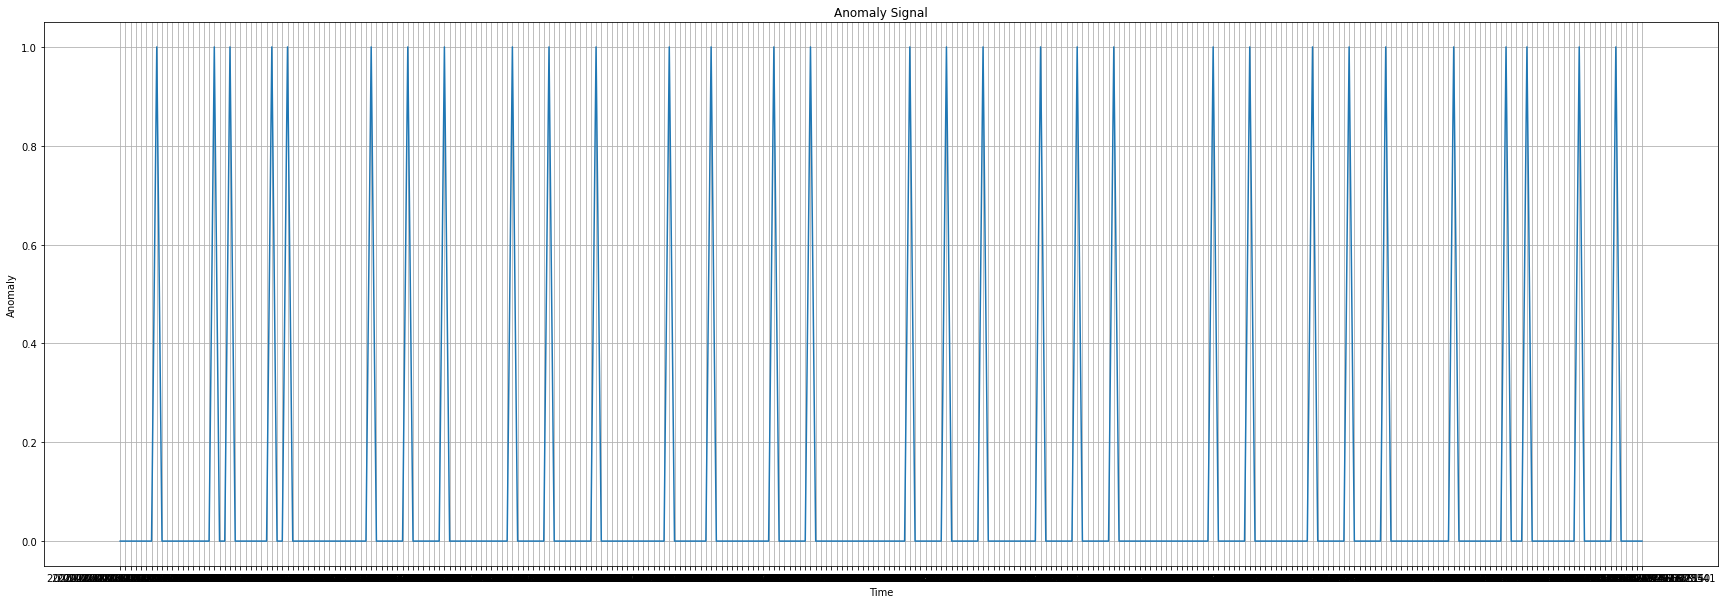

In [40]:
anomaly_signal = classify_df.loc[:, ['date_stamp', 'Anomaly']]
fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(anomaly_signal.date_stamp, anomaly_signal.Anomaly)
ax.set_xlabel('Time')
ax.set_ylabel('Anomaly')
ax.set_title('Anomaly Signal')
ax.grid(True)

I also implemented a LSTM model and got the results but they were not as good as ARIMA model. Although I think I can work on this model and make it better.

In [57]:
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
#### LSTM
supervised = timeseries_to_supervised(quantity_log, 1)
supervised_values = supervised.values
# split data into train and test-sets
train_lstm, test_lstm = supervised_values[0:index], supervised_values[index:]
# transform the scale of the data
scaler, train_scaled_lstm, test_scaled_lstm = scale(train_lstm, test_lstm)
# fit the model                 batch,Epoch,Neurons
lstm_model = fit_lstm(train_scaled_lstm, 1, 850 , 3)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled_lstm[:, 0].reshape(len(train_scaled_lstm), 1, 1)
#lstm_model.predict(train_reshaped, batch_size=1)

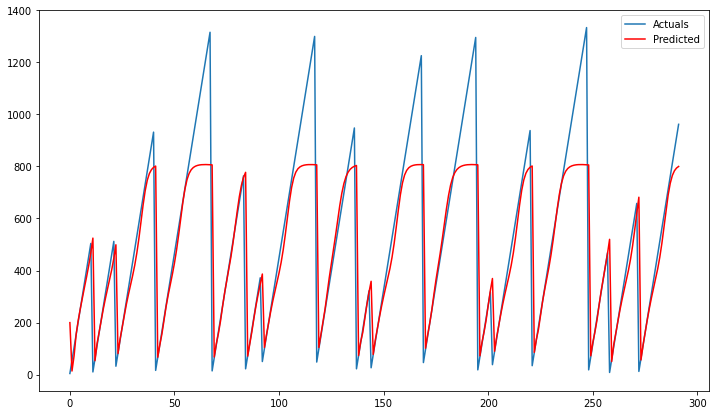

In [58]:
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.tools as tls
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled_lstm)):
#make one-step forecast
    X, y = test_scaled_lstm[i, 0:-1], test_scaled_lstm[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    #yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(10**yhat)
    expected = quantity_log[len(train_lstm) + i ]
# line plot of observed vs predicted
figsize=(12, 7)
plt.figure(figsize=figsize)
pyplot.plot(quantity_vals[index:],label='Actuals')
pyplot.plot(predictions, color = "red",label='Predicted')
pyplot.legend(loc='upper right')
pyplot.show()